#### Importing Necessary Libraries:

In [50]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc

#### Loading the dataset:

In [29]:
# read csv file
df = pd.read_csv('/Users/alexandroskyriakopoulos/Desktop/NLP/Final/Code/HuffPost22.csv')

#### Inspecting the Data:

In [30]:
print(df.shape)
df.head()

(209527, 6)


,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [33]:
print("Unique categories:",df['category'].nunique())
print(df['category'].unique())
df['category'].value_counts()

Unique categories: 42
['U.S. NEWS' 'COMEDY' 'PARENTING' 'WORLD NEWS' 'CULTURE & ARTS' 'TECH'
 'SPORTS' 'ENTERTAINMENT' 'POLITICS' 'WEIRD NEWS' 'ENVIRONMENT'
 'EDUCATION' 'CRIME' 'SCIENCE' 'WELLNESS' 'BUSINESS' 'STYLE & BEAUTY'
 'FOOD & DRINK' 'MEDIA' 'QUEER VOICES' 'HOME & LIVING' 'WOMEN'
 'BLACK VOICES' 'TRAVEL' 'MONEY' 'RELIGION' 'LATINO VOICES' 'IMPACT'
 'WEDDINGS' 'COLLEGE' 'PARENTS' 'ARTS & CULTURE' 'STYLE' 'GREEN' 'TASTE'
 'HEALTHY LIVING' 'THE WORLDPOST' 'GOOD NEWS' 'WORLDPOST' 'FIFTY' 'ARTS'
 'DIVORCE']


category
POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1444
FIFTY              1401
GOOD NEWS          1398
U.S. NEWS          1377
ARTS & CULTURE     1339
COLLEGE            1144
LATINO VOICES      1130
CULTURE & ARTS     1074
EDUCATI

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   link               209527 non-null  object
 1   headline           209521 non-null  object
 2   category           209527 non-null  object
 3   short_description  189815 non-null  object
 4   authors            172109 non-null  object
 5   date               209527 non-null  object
dtypes: object(6)
memory usage: 9.6+ MB


In [35]:
df.describe()

,link,headline,category,short_description,authors,date
count,209527,209521,209527,189815,172109,209527
unique,209486,207995,42,187021,29168,3890
top,https://www.huffingtonpost.comhttps://www.wash...,Sunday Roundup,POLITICS,Welcome to the HuffPost Rise Morning Newsbrief...,Lee Moran,2014-03-25
freq,2,90,35602,192,2954,100


In [36]:
df.isnull().sum()

link                     0
headline                 6
category                 0
short_description    19712
authors              37418
date                     0
dtype: int64

#### Data Preprocessing:

#### Dropping both missing headlines and short descriptions

In [37]:
# drop the rows when short_description and headline are missing
filtered_df = df.dropna(subset=['short_description', 'headline'])
print(df.isnull().sum())

link                     0
headline                 6
category                 0
short_description    19712
authors              37418
date                     0
dtype: int64


In [38]:
filtered_df.isna().sum()

link                     0
headline                 0
category                 0
short_description        0
authors              32955
date                     0
dtype: int64

In [39]:
# print the percentage of rows dropped
print(f'Percentage of rows dropped: {((len(df)-len(filtered_df))/len(df)*100):.2f}%')

Percentage of rows dropped: 9.41%


In [40]:
# Function to merge 'headline' and 'short_description' with " - " separator
def merge_columns(row):
    if pd.isna(row['short_description']):
        return row['headline']
    else:
        return f"{row['headline']}: {row['short_description']}"

# Apply the function to create a new column
filtered_df['news'] = filtered_df.apply(merge_columns, axis=1)

/var/folders/0b/z5bt_h_s57n7v_y1ct9cp55h0000gn/T/ipykernel_38978/3441550291.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['news'] = filtered_df.apply(merge_columns, axis=1)


In [41]:
filtered_df = filtered_df[['news', 'category']]
filtered_df.head()

,news,category
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY
3,The Funniest Tweets From Parents This Week (Se...,PARENTING
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS


#### Creating different news categories

In [42]:
categories_to_drop = [
    'IMPACT',
    'RELIGION', 
    'MEDIA',
    'SCIENCE', 
    'CRIME',
    'HOME & LIVING', 
    'WOMEN', 
    'WEIRD NEWS', 
    'FIFTY', 
    'GOOD NEWS', 
    'ARTS & CULTURE',
    'DIVORCE',
    'WEDDINGS',
    'QUEER VOICES',
    'BLACK VOICES',
    'LATINO VOICES',
    'U.S. NEWS',
    'COLLEGE',
    'EDUCATION',
]

category_mapping1 = {
    'POLITICS': 'POLITICS',
    'WELLNESS': 'WELLNESS',
    'HEALTHY LIVING': 'WELLNESS',
    'ENTERTAINMENT': 'ART & ENTERTAINMENT',
    'COMEDY': 'ART & ENTERTAINMENT',
    'ARTS': 'ART & ENTERTAINMENT',
    'CULTURE & ARTS': 'ART & ENTERTAINMENT',
    'TRAVEL': 'TRAVEL',
    'STYLE & BEAUTY': 'STYLE & BEAUTY',
    'STYLE': 'STYLE & BEAUTY',
    'PARENTING': 'PARENTING',
    'PARENTS': 'PARENTING',
    'FOOD & DRINK': 'GASTRONOMY',
    'TASTE': 'GASTRONOMY',
    'BUSINESS': 'BUSINESS & TECH',
    'MONEY': 'BUSINESS & TECH',
    'TECH': 'BUSINESS & TECH',
    'SPORTS': 'SPORTS',
    'THE WORLDPOST': 'WORLD NEWS',
    'WORLD NEWS': 'WORLD NEWS',
    'WORLDPOST': 'WORLD NEWS',
    'GREEN': 'ENVIRONMENT',
    'ENVIRONMENT': 'ENVIRONMENT',
}

filtered_df = filtered_df[~filtered_df['category'].isin(categories_to_drop)]
filtered_df['category'] = filtered_df['category'].map(category_mapping1)

In [43]:
print(filtered_df.shape)
print("Unique categories:",filtered_df['category'].nunique())
print(filtered_df['category'].unique())
filtered_df['category'].value_counts()

(143493, 2)
Unique categories: 11
['ART & ENTERTAINMENT' 'PARENTING' 'WORLD NEWS' 'BUSINESS & TECH' 'SPORTS'
 'POLITICS' 'ENVIRONMENT' 'WELLNESS' 'STYLE & BEAUTY' 'GASTRONOMY'
 'TRAVEL']


category
POLITICS               32441
WELLNESS               23208
ART & ENTERTAINMENT    21342
PARENTING              12346
STYLE & BEAUTY         11369
TRAVEL                  9421
BUSINESS & TECH         8990
GASTRONOMY              8271
WORLD NEWS              8203
SPORTS                  4414
ENVIRONMENT             3488
Name: count, dtype: int64

# BERT

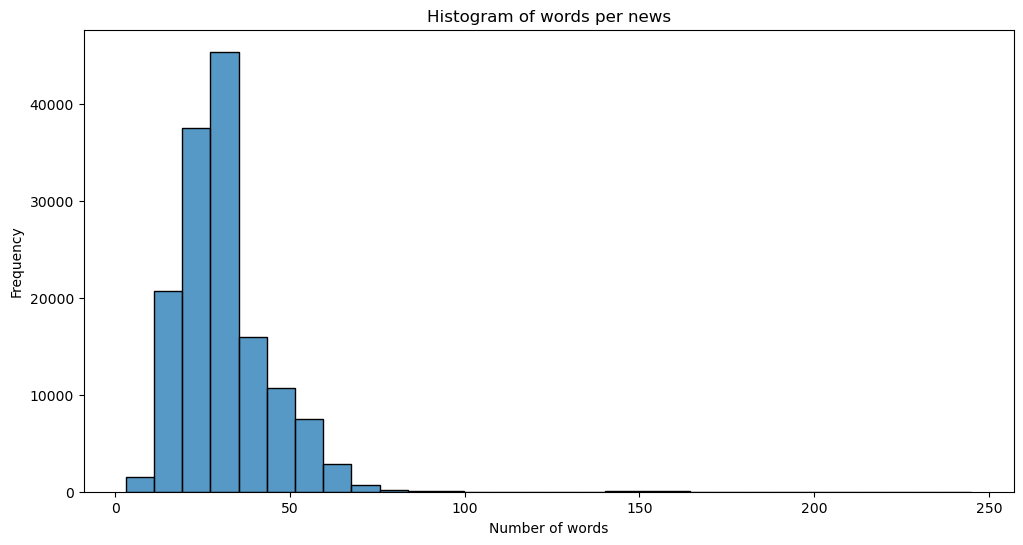

In [44]:
# histogram of words per news column with seaborn
import seaborn as sns
import matplotlib.pyplot as plt

filtered_df['news_length'] = filtered_df['news'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12, 6))
sns.histplot(filtered_df['news_length'], bins=30)
plt.title('Histogram of words per news')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.show()

In [45]:
# Label encoding
label_encoder = LabelEncoder()
filtered_df['encoded_category'] = label_encoder.fit_transform(filtered_df['category'])

In [46]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(filtered_df['news'], filtered_df['encoded_category'], test_size=0.2, random_state=42, stratify=filtered_df['encoded_category'])

# Tokenize the data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#set to 64 since most entries have less than 50 words
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=64)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=64)

/Users/alexandroskyriakopoulos/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [47]:
# Convert to TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).shuffle(1000).batch(8)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(8)

In [48]:
# Load pre-trained BERT model with a classification head
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=filtered_df['encoded_category'].nunique())

# Define the optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


# Train the model
model.fit(train_dataset, epochs=3, validation_data=test_dataset, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Get predictions for test data
y_pred_logits = model.predict(test_dataset).logits
y_pred = np.argmax(y_pred_logits, axis=1)

# Calculate precision, recall, and f1 score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Test Precision: {precision}')
print(f'Test Recall: {recall}')
print(f'Test F1 Score: {f1}')
print(f'Test Accuracy: {accuracy}')

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


2024-05-29 00:55:07.195171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [114794,64]
	 [[{{node Placeholder/_2}}]]
2024-05-29 00:55:07.195419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [114794]
	 [[{{node Placeholder/_3}}]]
2024-05-29 00:55:12.469056: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


14350/14350 [==============================] - ETA: 0s - loss: 0.5994 - accuracy: 0.8144

2024-05-29 09:08:37.907259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [28699]
	 [[{{node Placeholder/_3}}]]


14350/14350 [==============================] - 32118s 2s/step - loss: 0.5994 - accuracy: 0.8144 - val_loss: 0.5044 - val_accuracy: 0.8392
Epoch 2/3
14350/14350 [==============================] - 31352s 2s/step - loss: 0.3957 - accuracy: 0.8753 - val_loss: 0.5077 - val_accuracy: 0.8391
Epoch 3/3
3588/3588 [==============================] - 1569s 437ms/step - loss: 0.5044 - accuracy: 0.8392
Test Loss: 0.50435471534729
Test Accuracy: 0.8391929864883423
3588/3588 [==============================] - 1485s 413ms/step
Test Precision: 0.8407993385797211
Test Recall: 0.839193003240531
Test F1 Score: 0.8374902452096321
Test Accuracy: 0.8391929864883423


                     precision    recall  f1-score   support

ART & ENTERTAINMENT       0.85      0.82      0.84      4268
          PARENTING       0.84      0.60      0.70      1798
         WORLD NEWS       0.64      0.71      0.68       698
    BUSINESS & TECH       0.87      0.84      0.86      1654
             SPORTS       0.85      0.78      0.81      2469
           POLITICS       0.85      0.92      0.88      6488
        ENVIRONMENT       0.80      0.86      0.83       883
           WELLNESS       0.80      0.92      0.86      2274
     STYLE & BEAUTY       0.80      0.91      0.85      1884
         GASTRONOMY       0.87      0.85      0.86      4642
             TRAVEL       0.85      0.76      0.81      1641

           accuracy                           0.84     28699
          macro avg       0.82      0.82      0.81     28699
       weighted avg       0.84      0.84      0.84     28699



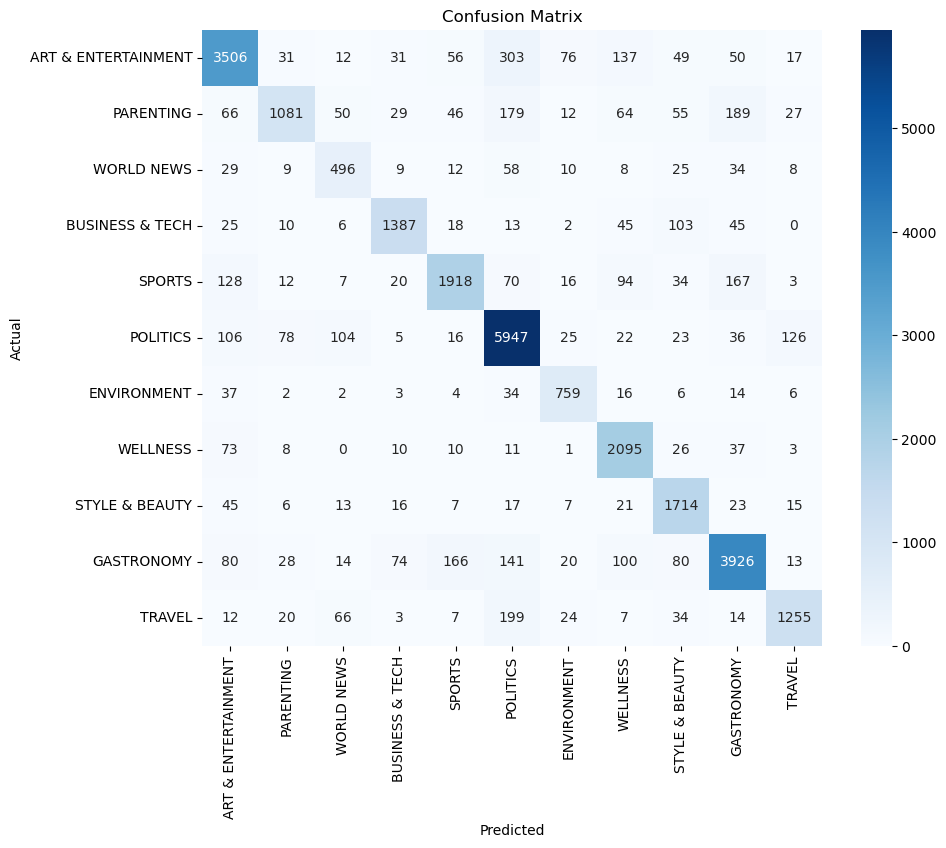

In [51]:
# Classification report
class_names = list(filtered_df['category'].unique())
report = classification_report(y_test, y_pred, target_names=class_names)
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()